### Disclaimer

This file involves data preprocessing from the source file and can only be run under an ArcGIS Online Account. The processed data is located in the [Google Drive](https://drive.google.com/drive/folders/1wpifXxdnxIrisuvbvu8xhulW7McIjEPo?usp=sharing) and could be directly downloaded and used without such an account.

### Setup

In [1]:
# external core
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # Higher resolution figures

# gis
import arcgis
from arcgis.gis import GIS
from arcgis import geocoding
from shapely.geometry import Point

# utility
import re
import time
import csv
import nltk
import getpass
from datetime import datetime
from tqdm.notebook import tqdm

In [2]:
# connect to AGOL
username = input('Enter username: ')
password = getpass.getpass("Enter password: ")
gis = GIS(username=username, password=password)

Enter username: dsc170wi22_45
Enter password: ········


### San Diego City Boundary

<AxesSubplot:>

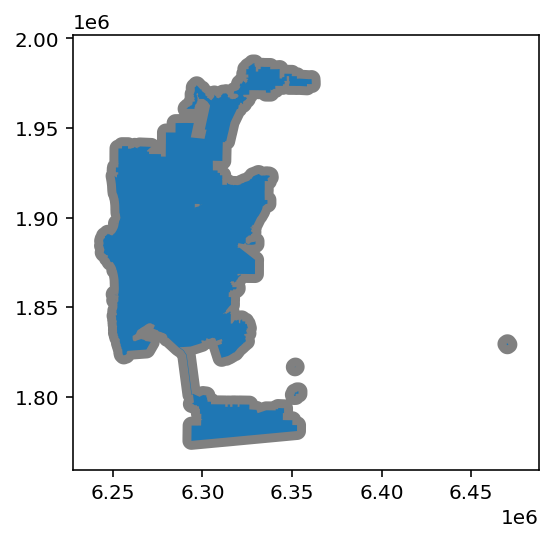

In [3]:
sd_boundary = gpd.read_file('../data/san_diego_boundary_datasd.shp').dissolve()
sd_boundary_buffer = gpd.GeoDataFrame({'name': ['City of San Diego Buffer']}, geometry=sd_boundary.buffer(5000))
boundary_ax = sd_boundary_buffer.plot(color='gray')
sd_boundary.plot(ax=boundary_ax, color='C0')

### Load Accidents

In [4]:
accidents = pd.read_csv('../data/pd_collisions_datasd_v1.csv')
accidents = accidents[
    (~accidents['address_road_primary'].isna()) &
    (~accidents['address_sfx_primary'].isna())
].reset_index(drop=True)
accidents.head(5)

,report_id,date_time,police_beat,address_no_primary,address_pd_primary,address_road_primary,address_sfx_primary,address_pd_intersecting,address_name_intersecting,address_sfx_intersecting,violation_section,violation_type,charge_desc,injured,killed,hit_run_lvl
0,171111,2015-01-14 20:00:00,835,4200,,JUNIPER,STREET,,,,MISC-HAZ,VC,MISCELLANEOUS HAZARDOUS VIOLATIONS OF THE VEHI...,0,0,MISDEMEANOR
1,192016,2015-03-19 12:00:00,622,5200,,LINDA VISTA,ROAD,,,,MISC-HAZ,VC,MISCELLANEOUS HAZARDOUS VIOLATIONS OF THE VEHI...,0,0,MISDEMEANOR
2,190012,2015-03-24 03:05:00,626,1000,W,WASHINGTON,STREET,,,,22107,VC,TURNING MOVEMENTS AND REQUIRED SIGNALS,2,0,NaN
3,191866,2015-03-27 23:56:00,613,2800,,WORDEN,STREET,,,,22107,VC,TURNING MOVEMENTS AND REQUIRED SIGNALS,1,0,NaN
4,185207,2015-07-06 11:45:00,813,2800,,EL CAJON,BOULEVARD,,,,20002(A),VC,HIT AND RUN,0,0,MISDEMEANOR


#### Geocoding

In [5]:
# SLOW, FOR GEOCODING
# addresses = accidents.apply(lambda row: re.sub(' +', ' ', ' '.join(map(str, row[[
#     'address_no_primary', 
#     'address_pd_primary', 
#     'address_road_primary', 
#     'address_sfx_primary'
# ]].values))) + ', San Diego, CA', axis=1).tolist()

In [6]:
# COSTLY, RUN WITH CARE
# accident_lat_long = geocoding.batch_geocode(addresses, out_sr={'wkid': 4326}, as_featureset=True)
# accident_locations_sdf = accident_lat_long.sdf
# accident_locations_sdf['ResultID'] = accident_locations_sdf.apply(
#     lambda row: (row.name // 1000) * 1000 + row['ResultID'], 
#     axis=1
# )
# accident_locations_sdf.shape

In [7]:
# upload to ArcGIS Online
# location_layer = accident_locations_sdf.spatial.to_featurelayer(title='City of San Diego Accident Locations')

#### Load Geocoding Results

In [8]:
# get layer
location_layer = gis.content.get('665ab51ec9974b71bcca00988ae5ff5d')
accident_locations_sdf = location_layer.layers[0].query().sdf

In [9]:
accidents_sd_location = gpd.GeoDataFrame(
    accidents
    .merge(
        accident_locations_sdf[['result_id', 'x', 'y', 'SHAPE']], 
        how='left', 
        left_index=True, 
        right_on='result_id'
    ).set_index('result_id')
)

accidents_gdf = gpd.GeoDataFrame(accidents_sd_location, crs='EPSG:4326', geometry=[
    Point(xy) for xy in zip(accidents_sd_location['x'], accidents_sd_location['y'])
]).sjoin(sd_boundary_buffer.to_crs('EPSG:4326')).drop(columns=['index_right', 'name'])

### Other Data

#### Get It Done Reports

In [10]:
reports = pd.read_csv('../data/get_it_done_requests_open_datasd.csv')

In [11]:
reports_gdf = gpd.GeoDataFrame(reports, crs='EPSG:4326', geometry=[
    Point(xy) for xy in zip(reports['lng'], reports['lat'])
]).sjoin(sd_boundary_buffer.to_crs('EPSG:4326')).drop(columns=['index_right', 'name'])

#### Roads

In [12]:
roads = (
    gpd
    .read_file('../data/roads_datasd.shp')
    .sjoin(sd_boundary_buffer)
    .drop(columns=['index_right', 'name'])
)
roads_buffer = gpd.GeoDataFrame(roads.to_dict('list'), geometry=roads.buffer(40)).to_crs('EPSG:4326')
roads = roads.to_crs('EPSG:4326')

#### Vehicles and People Involved

Data Source: https://data.sandiego.gov/datasets/police-collisions-details/<br>
Data Format: CSV

In [13]:
veh_ppl = pd.read_csv('../data/pd_collisions_details_datasd.csv')
veh_ppl_nonull = veh_ppl[veh_ppl['report_id'].isin(accidents_gdf['report_id'])][[
    'report_id', 'person_role', 'veh_make', 'veh_model'
]]

In [14]:
veh_ppl_info = veh_ppl_nonull.loc[veh_ppl_nonull.drop(columns=['report_id']).dropna(how='all').index]
veh_ppl_info.head(1)

,report_id,person_role,veh_make,veh_model
0,171111,PARKED VEHICLE OCCUPANT,TOYOTA,RAV4


### Finalize Tables

In [15]:
# finalize accidents table
accidents_gdf.drop(columns=['SHAPE', 'geometry']).to_csv('../data/accidents.csv', index=False)

In [16]:
# finalize report table
reports_gdf = reports_gdf[~reports_gdf[['street_address', 'council_district']].isna().any(axis=1)]
reports_gdf['council_district'] = reports_gdf['council_district'].astype(int)
reports_gdf['street_address'] = reports_gdf['street_address'].str.replace(',', '')
reports_gdf.drop(columns=['geometry']).to_csv('../data/reports.csv', index=False)

In [17]:
# finalize accident info table
veh_ppl_info['veh_make'] = veh_ppl_info['veh_make'].str.replace(',', '')
veh_ppl_info['veh_model'] = veh_ppl_info['veh_model'].str.replace('(, *)', '/', regex=True)
veh_ppl_info.to_csv('../data/accident_info.csv', index=False)

In [18]:
# finalize road table
roads.drop(columns=['geometry']).to_csv('../data/roads.csv', index=False)

In [19]:
# finalize accidents <-> road
accidents_with_road = accidents_gdf.sjoin(roads_buffer[['objectid', 'geometry']], how='left')
filtered_accidents_road = accidents_with_road[~accidents_with_road['objectid'].isna()][['report_id', 'objectid']]
filtered_accidents_road['objectid'] = filtered_accidents_road['objectid'].astype(int).astype(str)
filtered_accidents_road.to_csv('../data/accidents_on_road.csv', index=False)

In [20]:
# finalize reports <-> road
reports_with_road = reports_gdf.sjoin(roads_buffer[['objectid', 'geometry']], how='left')
filtered_reports_road = reports_with_road[
    (~reports_with_road['objectid'].isna()) &
    (reports_with_road['service_request_id'].isin(reports_gdf['service_request_id']))
][['service_request_id', 'objectid']]
filtered_reports_road['objectid'] = filtered_reports_road['objectid'].astype(int).astype(str)
filtered_reports_road.to_csv('../data/reports_on_road.csv', index=False)